<strong><h1>Introduction</strong></h1>

We are determining what neighborhood would be the safest to be in during a fire, with the "best" being the safest and the "worst" being the least safe. The submetrics used are previous fire incidents in the neighborhood, the neighborhood that could burn down the slowest, and the most effective fire departments.



In [12]:
import pandas as pd
import numpy as np
%matplotlib inline
import geopandas
import matplotlib.pyplot as plt
from heapq import nsmallest


In [13]:
#Here we can see there is a lot of information we don't need. By only looking at the number of fire incidents
#I really only need one column, neighborhoods. I show neighborhoods and incident type because later I will see the distribution of the types of fires
fire = pd.read_csv("fireIncidents.csv")
fire.iloc[0:]

,call_no,incident_type,type_description,address,alarm_time,alarms,primary_unit,census_tract,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude
0,F160029985,111.0,Building fire,"800 BLOCK CENTER ST, WILKINSBURG PA 15221",2016-04-21T05:01:04,1,231EN16,NaN,NaN,NaN,NaN,4.200356e+10,NaN,NaN,NaN,3-16,40.441275,-79.882485
1,F180022058,111.0,Building fire,"1100 BLOCK JANE ST, WILKINSBURG PA 15221",2018-03-13T08:34:43,1,231EN16,NaN,NaN,NaN,NaN,4.200356e+10,NaN,NaN,NaN,3-21,40.436342,-79.881003
2,F180022102,131.0,Passenger vehicle fire,"SB STATE HWY 28 SB AT 31S, PITTSBURGH PA 15212",2018-03-13T11:54:23,0,231EN32,2406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-1A,NaN,NaN
3,F170043431,131.0,Passenger vehicle fire,"1700 BLOCK BELLEAU DR, PITTSBURGH PA 15212",2017-05-31T08:39:47,0,231EN38,2509.0,Fineview,6.0,25.0,4.200325e+10,1.0,25.0,1.0,1-10,40.460303,-80.006980
4,F180021111,111.0,Building fire,"2400 BLOCK VILLAGE RD, PITTSBURGH PA 15205",2018-03-09T10:26:42,1,231EN31,2808.0,Fairywood,2.0,28.0,4.200356e+10,5.0,28.0,6.0,1-16,40.449009,-80.076607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8922,F220082010,130.0,"Mobile property (vehicle) fire, Other","4400 BLOCK BROWNS HILL RD, PITTSBURGH PA 15218",2022-11-03T17:46:47,0,231EN19,1517.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-12,NaN,NaN
8923,F220082038,113.0,"Cooking fire, confined to container","600 BLOCK HOLLACE ST, PITTSBURGH PA 15211",2022-11-03T19:13:44,1,231EN10,501.0,Middle Hill,6.0,5.0,4.200305e+10,3.0,5.0,2.0,2-5,40.449953,-79.967408
8924,F220082248,111.0,Building fire,"2400 BLOCK WATERMAN AVE, PITTSBURGH PA 15227",2022-11-04T12:35:38,1,231EN23,2904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-15,NaN,NaN
8925,F220082275,142.0,Brush or brush-and-grass mixture fire,"100 BLOCK REDLYN ST, PITTSBURGH PA 15223",2022-11-04T14:22:12,0,231EN23,3001.0,Knoxville,3.0,30.0,4.200330e+10,5.0,30.0,3.0,4-7,40.413520,-79.991463


In [14]:
#This looks much better and we now see only the neighborhoods and their incident type
#"NaN" will pop up as the listed neighborhood multiple times. There is not much we can do about that so I will be ignoring any data with "NaN" as the neighborhood

fire = pd.read_csv("fireIncidents.csv")
fire
data = pd.read_csv("fireIncidents.csv", index_col="neighborhood", parse_dates=True)
del data["police_zone"]
del data["call_no"]
del data["address"]
del data["alarm_time"]
del data["alarms"]
del data["primary_unit"]
del data["census_tract"]
del data["ward"]
del data["council_district"]
del data["tract"]
del data["public_works_division"]
del data["pli_division"]
del data["fire_zone"]
del data["latitude"]
del data["longitude"]
del data["incident_type"]

data

,type_description
neighborhood,
NaN,Building fire
NaN,Building fire
NaN,Passenger vehicle fire
Fineview,Passenger vehicle fire
Fairywood,Building fire
...,...
NaN,"Mobile property (vehicle) fire, Other"
Middle Hill,"Cooking fire, confined to container"
NaN,Building fire


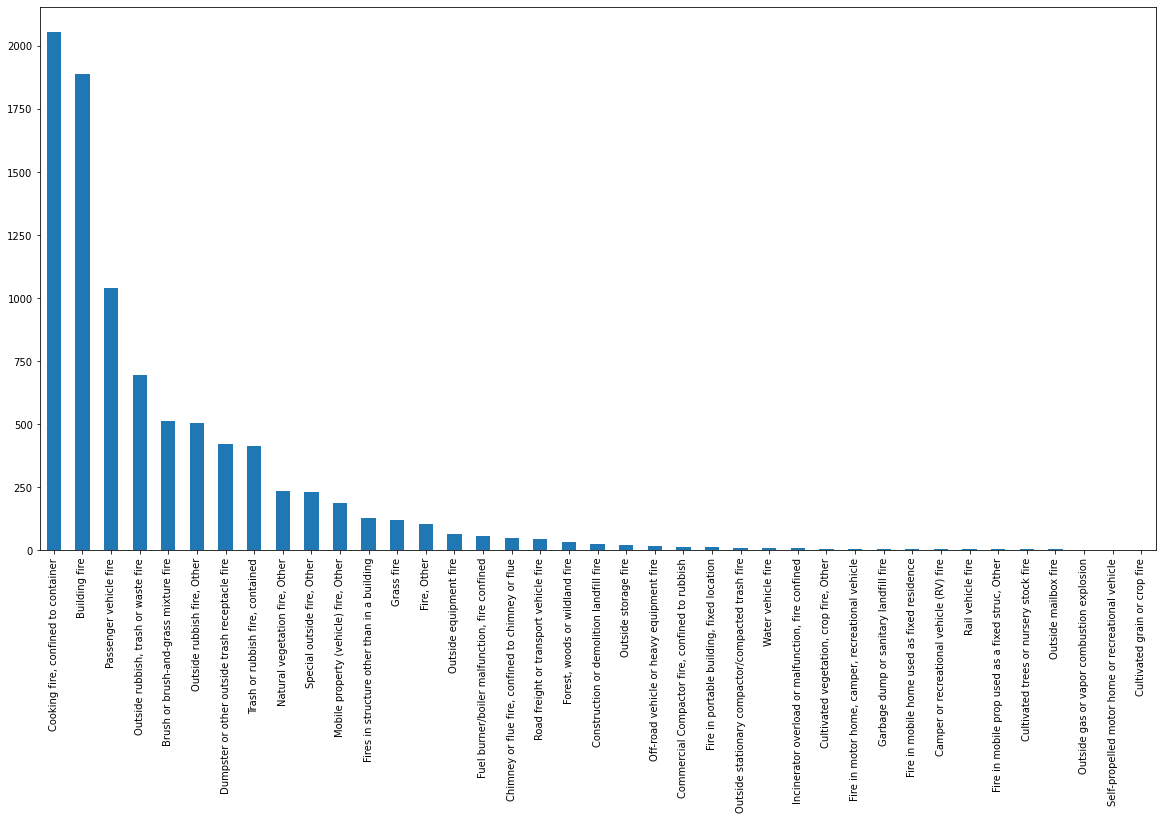

In [15]:
#Here I am checking whether or not I should weigh the types of fires as well as their prevalance in each neighborhood #
#I came to the conclusion that since 26 of the types of fire incidents have less that 100 occurences, I will just be looking at the total amount of fire incidents in each neighborhood.
data3 = data['type_description'].value_counts()
data3.plot.bar(figsize = (20,10))

In [16]:
#Looking at the total number of fire incidents in each neighborhood using .value_counts(), I see that Carrick, the Central Business District, Squirrel Hill South, South Side Flats, and Hazelwood 
#have had the most fire incidents in the past 5 years 
#St. Clair, East Carnegie, Mt. Oliver, Regent Square, and Mount Oliver Borough have had the least incidents
#I will then plot a bar graph displaying the total number of fires in all neighborhoods
data2 = fire['neighborhood'].value_counts()
data2

Carrick                      275
Central Business District    247
Squirrel Hill South          242
South Side Flats             239
Hazelwood                    230
                            ... 
St. Clair                     11
East Carnegie                 11
Mt. Oliver                    11
Regent Square                  8
Mount Oliver Borough           6
Name: neighborhood, Length: 91, dtype: int64

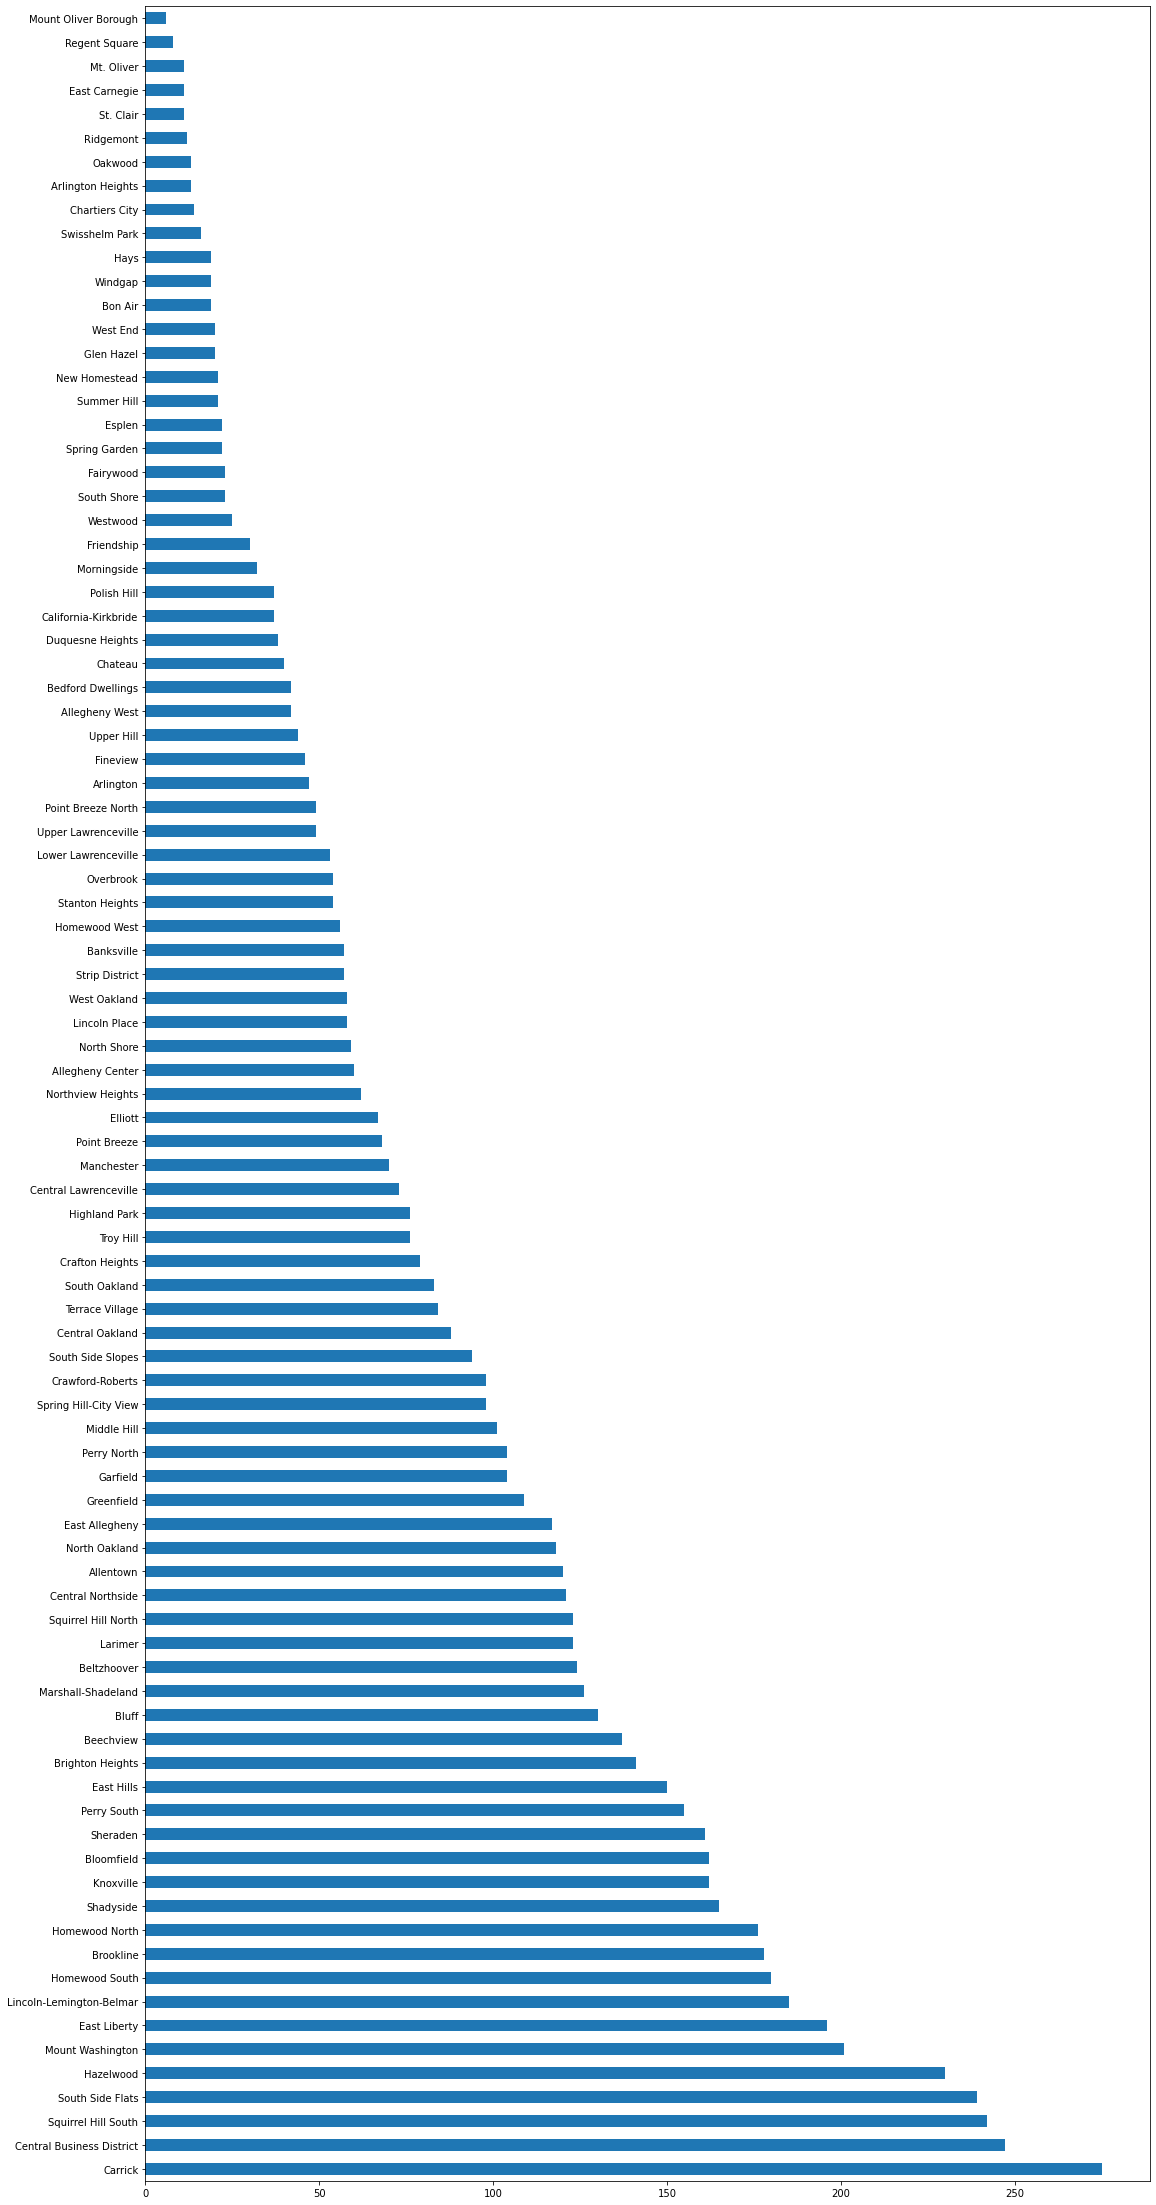

In [17]:
data2.plot.barh(figsize = (18,40))

In [18]:
#We cannot determine the best neighborhood for fire safety on this data alone
#Some neighborhoods are much larger than others, and naturally there will be more fires in bigger neighborhoods with more people and buildings 
#To figure out which neighboorhood is the best for fire safety, we need to look at the total number of fire incidents compared to the total population 
pop = pd.read_csv("population2.csv")
pop

,Neighborhood,2010_Total_Population,2010_OneRace_Population,2010_White_Alone_Population,2010_Black_Alone_Population,2010_American_Indian_and_Alaska_Native_alone_population,2010_Asian_Alone_Population,2010_Native_Hawaiian_and_Other_Pacific_Islander_alone_Populatio,2010_Any_other_single_race_alone_Popualtion,2010_Population_two_or_more_races,...,Change_2010_to_2020_Total_Population,Change_2010_to_2020_OneRace_Population,Change_2010_to_2020_White_Alone_Population,Change_2010_to_2020_Black_Alone_Population,Change_2010_to_2020_American_Indian_and_Alaska_Native_alone_pop,Change_2010_to_2020_Asian_Alone_Population,Change_2010_to_2020_Native_Hawaiian_and_Other_Pacific_Islander_,Change_2010_to_2020_Any_other_single_race_alone_Popualtion,Change_2010_to_2020_Population_two_or_more_races,Change_2010_to_2020_Hispanic_or_Latino_Population
0,Allegheny Center,933,896,381,453,4,56,1,1,37,...,486,441,302,-63,4,179,0,19,45,23
1,Allegheny West,462,448,354,84,1,7,0,2,14,...,78,45,72,-52,0,9,1,15,33,28
2,Allentown,2500,2384,1485,878,9,1,0,11,116,...,-195,-258,-213,-93,-6,18,6,30,63,23
3,Arlington - Arlington Heights (Combined),2113,2042,1452,576,9,3,0,2,71,...,-73,-153,-246,44,-4,9,0,44,80,39
4,Banksville,4144,4053,3651,169,2,211,0,20,91,...,-17,-197,-460,25,5,174,2,57,180,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,Upper Lawrenceville,2669,2590,1754,751,10,37,1,37,79,...,-275,-324,264,-597,-5,37,-1,-22,49,-17
85,West End,254,235,135,95,0,2,0,3,19,...,-49,-55,-17,-45,1,4,2,0,6,10
86,West Oakland,2604,2558,1373,1003,7,169,0,6,46,...,-70,-103,159,-395,-1,28,2,104,33,51
87,Westwood,3066,2980,2535,250,3,174,1,17,86,...,266,167,-339,28,0,418,1,59,99,78


In [19]:
#Here is a population dataset that I trim down to just the neighborhood and its population in 2020
#I will use these numbers combined with fire incidents to determine the safest neighborhood regarding fires.
pop2 = pop[["Neighborhood", "2020_Total_Population"]]

pop2

,Neighborhood,2020_Total_Population
0,Allegheny Center,1419
1,Allegheny West,540
2,Allentown,2305
3,Arlington - Arlington Heights (Combined),2040
4,Banksville,4127
...,...,...
84,Upper Lawrenceville,2394
85,West End,205
86,West Oakland,2534
87,Westwood,3332


In [20]:
#After putting everything into a dataset and dividing fires by population
#I multiply the average by 100 for the purpose of readability. I trim the dataset down to only look at the neighborhoods and their average x 100.
div = pd.read_csv("calculations.csv")
div

,Neighborhood,Fires,Population,Average,Average x 100
0,Allegheny Center,60,1419,0.042283,4.228330
1,Allegheny West,42,540,0.077778,7.777778
2,Allentown,120,2305,0.052061,5.206074
3,Arlington,47,2040,0.023039,2.303922
4,Banksville,57,4127,0.013811,1.381149
...,...,...,...,...,...
83,Upper Lawrenceville,49,2394,0.020468,2.046784
84,West End,20,205,0.097561,9.756098
85,West Oakland,58,2534,0.022889,2.288871
86,Westwood,25,3332,0.007503,0.750300


In [21]:
df2 = div[['Neighborhood', 'Average x 100']]
df2

,Neighborhood,Average x 100
0,Allegheny Center,4.228330
1,Allegheny West,7.777778
2,Allentown,5.206074
3,Arlington,2.303922
4,Banksville,1.381149
...,...,...
83,Upper Lawrenceville,2.046784
84,West End,9.756098
85,West Oakland,2.288871
86,Westwood,0.750300


In [22]:
#Before plotting I sort the values so the graph goes in order
df3= df2.sort_values('Average x 100',ascending=False)
df3

,Neighborhood,Average x 100
68,South Shore,79.310345
54,North Shore,19.601329
87,Windgap,14.179104
84,West End,9.756098
40,Homewood West,8.722741
...,...,...
65,Shadyside,1.077234
73,Squirrel Hill North,1.035441
49,Morningside,0.984010
63,Regent Square,0.823893


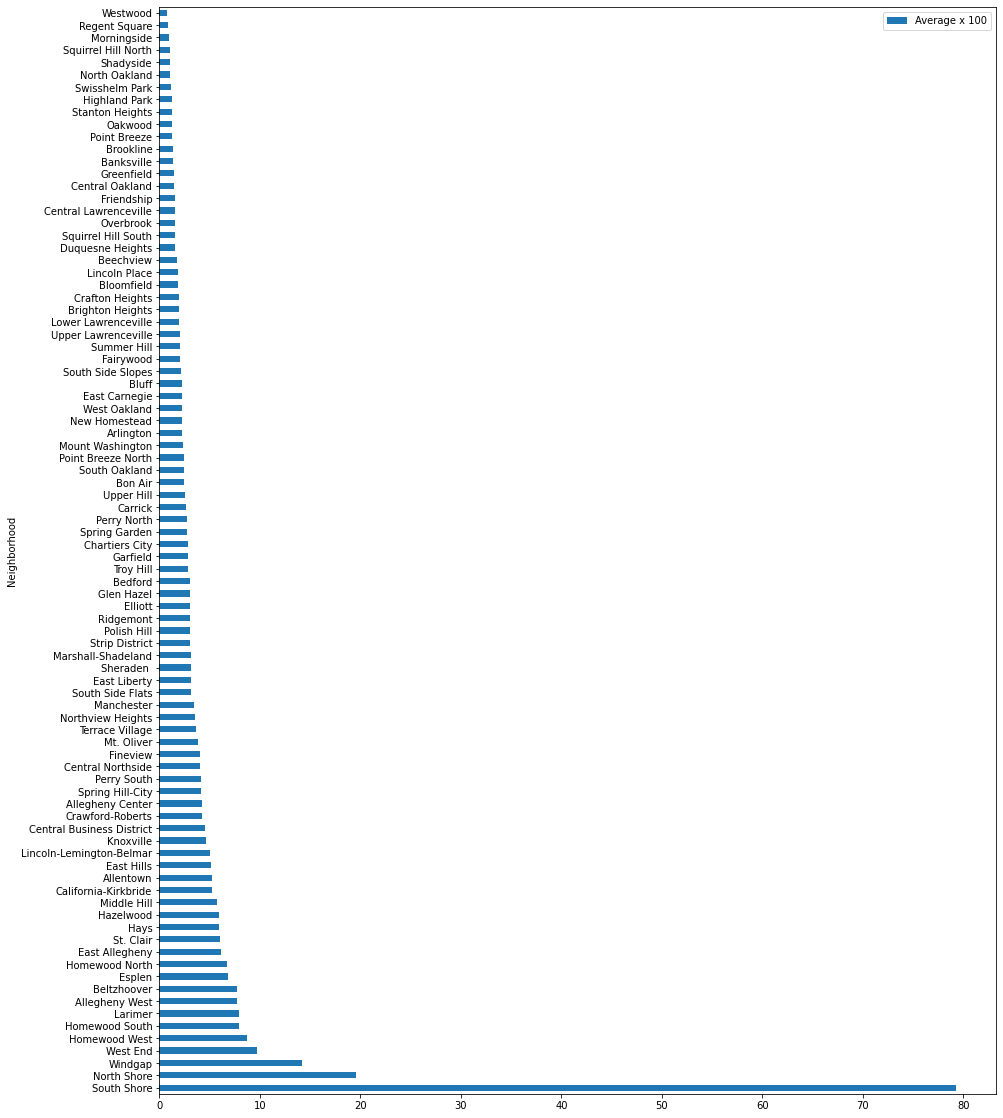

In [23]:
df3.plot.barh(x = "Neighborhood", y = "Average x 100", figsize = (15,20))

<strong><h1>Conclusion</strong></h1>
Based on the data, I have determined that South Shore is the best neighborhood. And with that, South Shore is the most prepared to stop fires. The entire neighborhood also borders water on one side adding to the comfort that South Shore is safe regarding fires.

<strong><h1>Building Density (Kameren Jouhal)</strong></h1>

In [48]:
buildings = pd.read_csv("Properties.csv")
neighborhoods = pd.read_csv("Neighborhoods.csv")

In [49]:
#use the iloc function to get the columns of information I need
neighborhoodsAcres = neighborhoods.iloc[:, [22]]
nName = neighborhoods.iloc[:, [20]]
bName = buildings.iloc[:, 5]
bName = bName.dropna()

In [50]:
#add all the neighborhoods to a list
neighborhoodList = []
for num in range(0, len(nName)):
    n = nName.iat[num, 0]
    neighborhoodList.append(n)

In [51]:
#create a dictionary of all city-owned buildings in specific neighborhoods
buildDictionary = {}
for num in range(0, len(bName)):
    b = bName.iloc[num]
    if b in neighborhoodList:
        if not b in buildDictionary.keys():
            buildDictionary[b] = 1
        else:
            buildDictionary[b] += 1

<BarContainer object of 82 artists>

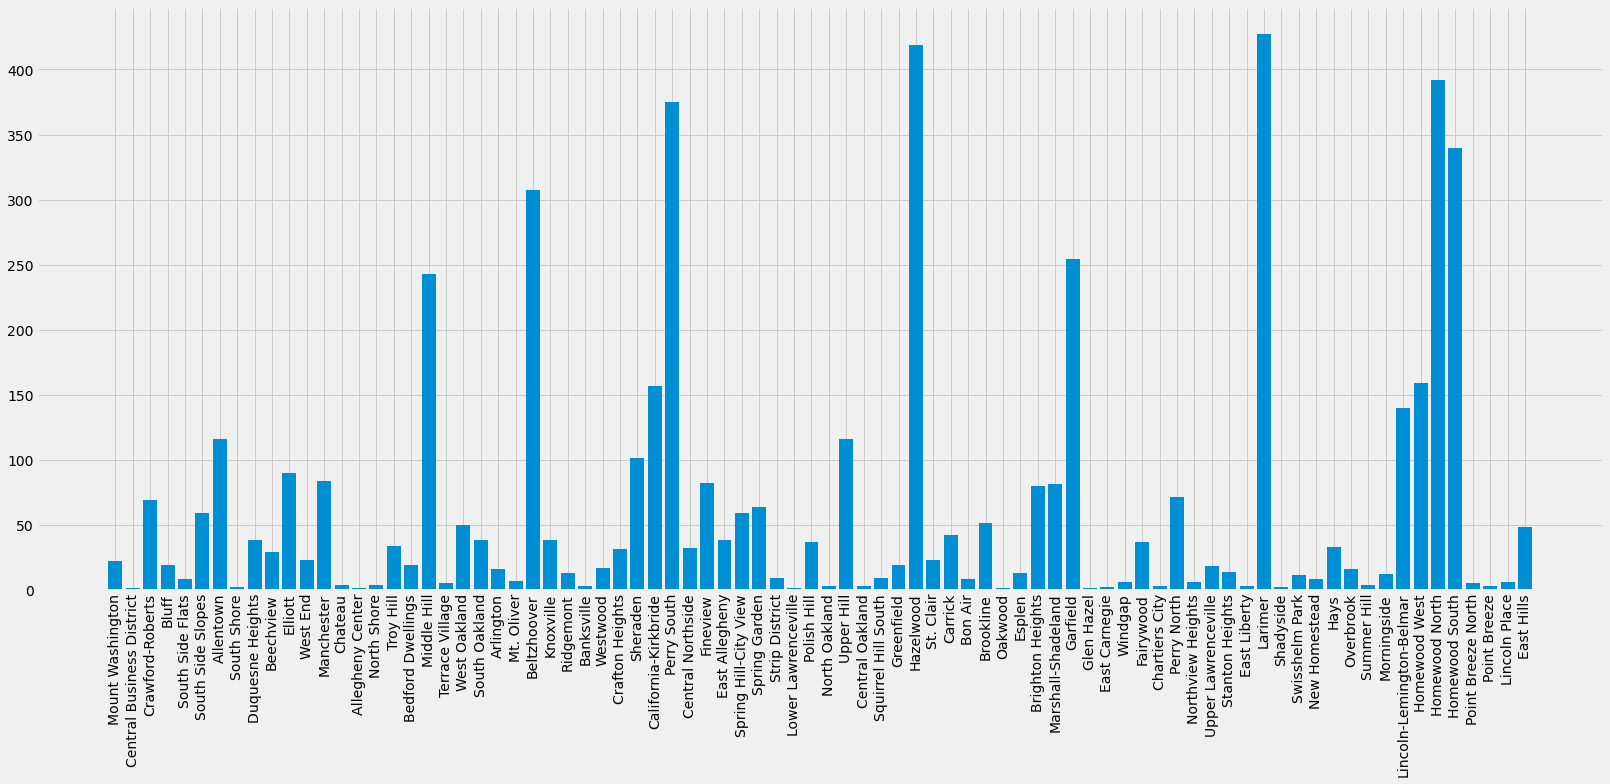

In [52]:
#create a bar graph for all the city-owned buildings
keys = buildDictionary.keys()
values = []
for key in buildDictionary.keys():
    values.append(buildDictionary[key])
plt.figure(figsize=(25, 10))
plt.xticks(rotation=90)
plt.bar(keys, values)

In [53]:
#create a dictionary to calculate the city-owned buildings per acre in each neighborhood
averageDictionary = {}
for num in range(0, len(nName)):
    n = nName.iat[num, 0]
    a = neighborhoodsAcres.iat[num, 0]
    if n in buildDictionary.keys() and a > 0:
        b = buildDictionary[n]
        averageDictionary[n] = a/b

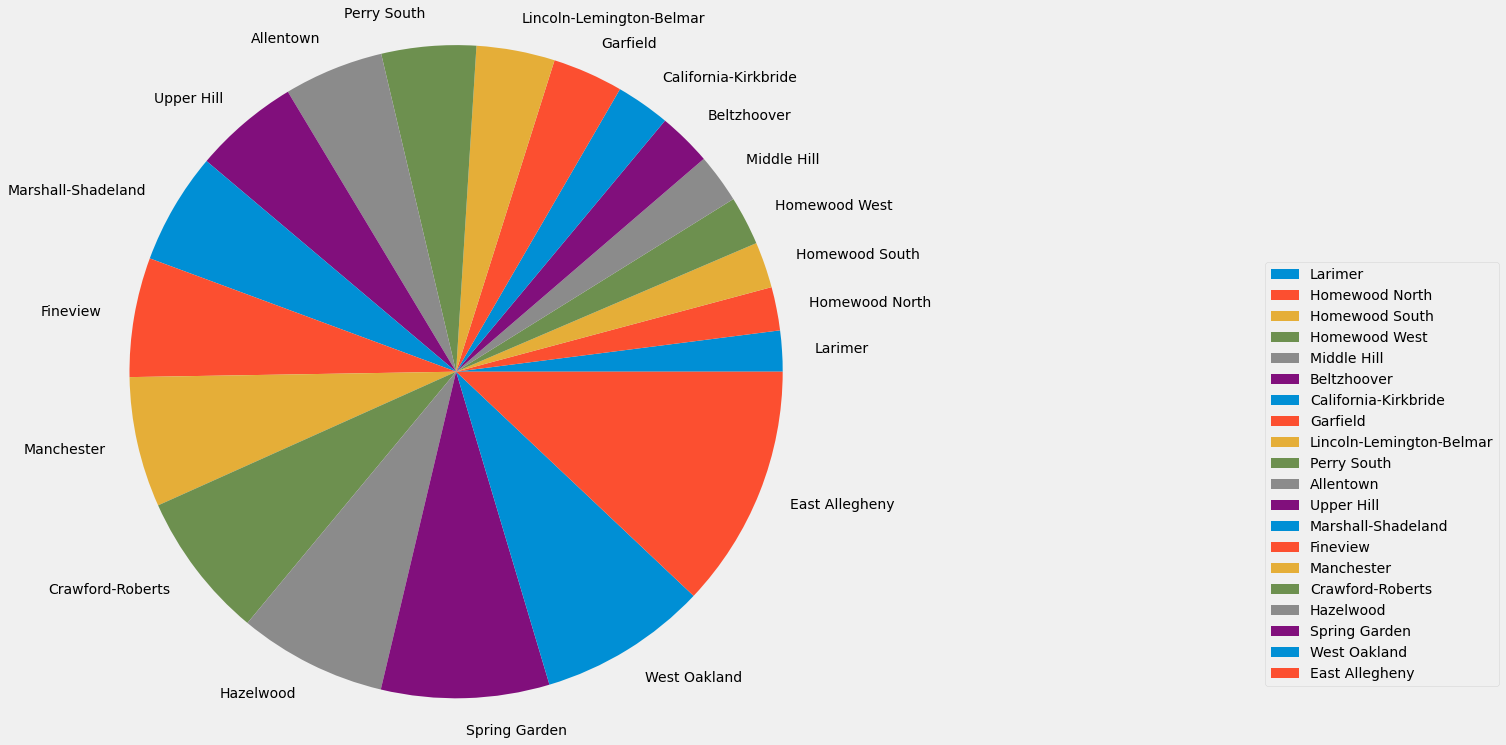

In [57]:
#create a pie chart of the top 20 from the dictionary above
avg = []
#based on code from https://www.geeksforgeeks.org/python-n-largest-values-in-dictionary/
myLabels = nsmallest(20, averageDictionary, key = averageDictionary.get)
for key in myLabels:
    avg.append(averageDictionary[key])
p = np.array(avg)
plt.pie(p, radius = 3.5, labels = myLabels)
plt.legend(bbox_to_anchor = (5, 1), labels = myLabels)
plt.show()

In [58]:
#display the neighborhood with the lowest buildings per acre
minimum = float("inf")
k = ""
for key in averageDictionary.keys():
    if averageDictionary[key] < minimum:
        minimum = averageDictionary[key]
        k = key
print("The neighborhood with the lowest city-owned buildings per acre is " + k + " with " 
      + str(minimum) + " buildings per acre")


The neighborhood with the lowest city-owned buildings per acre is Larimer with 0.6701639344262296 buildings per acre


<strong><h1>Conclusion</strong></h1>
Larimer is the best neighborhood to live in based on this metric because it has the lowest buildings per acre in the neighborhood, meaning the buildings are more spread out than other neighborhoods. This means that Larimer will burn down the slowest amongst all the neighborhoods.

<strong><h1>Firestations (Josh Sitler)</strong></h1>

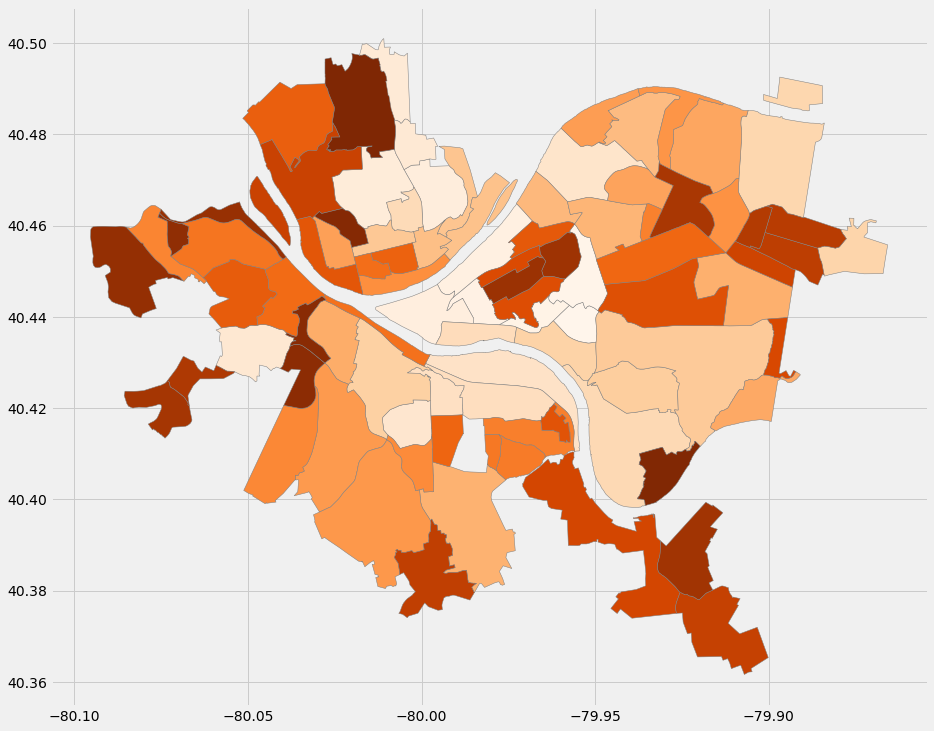

In [32]:
#sets the style for all the upcoming maps and charts
plt.style.use("fivethirtyeight")

#gives us the map of Pittsburgh
neighborhoodsMap = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
neighborhoodsMap.plot(color = "white", edgecolor = "grey", cmap = "Oranges", figsize = (14,14))

In [33]:
#takes from the population file and grabs the information we need from it
population = pd.read_csv("Population.csv", usecols = ["Neighborhood", "Estimate; Total"])

#sorts the information we grabbed by numerical order
population = population.sort_values("Estimate; Total")
population.iloc[0:]

,Neighborhood,Estimate; Total
21,Chateau,3.0
71,South Shore,12.0
57,North Shore,205.0
87,West End,235.0
78,St. Clair,270.0
...,...,...
15,Carrick,10122.0
76,Squirrel Hill North,11336.0
13,Brookline,13160.0
68,Shadyside,13562.0


In [34]:
#much like the prior one, this takes the dataset and selects a few columns that we need
facilities = pd.read_csv("Facilities.csv", usecols = ["name","longitude","latitude","neighborhood","type"])
#narrows down what we need by searching the dataset for the type "Firehouse"
firehouse = facilities[facilities["type"] == "Firehouse"]

#one of the firehouses was not picked up by the filter, so this is the information for it in a DataFrame
outlierFirehouse = pd.DataFrame({"latitude": [40.441413], "longitude": [-79.921139], "type": ["Firehouse"], "name": ["Firehouse 18 Police 04"], "neighborhood": ["Squirrel Hill North"]})

#combines the dataset with the DataFrame and puts it into a list
firehouse = firehouse.append(outlierFirehouse)
firehouse.iloc[0:]

<ipython-input-34-fd4b03008a27>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  firehouse = firehouse.append(outlierFirehouse)


,name,type,neighborhood,latitude,longitude
99,Firehouse 06,Firehouse,Lower Lawrenceville,40.464894,-79.958144
100,Firehouse 19,Firehouse,Swisshelm Park,40.420827,-79.899838
101,Firehouse 20 Medic 12,Firehouse,Hays,40.385781,-79.933013
102,Firehouse 24,Firehouse,South Side Flats,40.426354,-79.981299
103,Firehouse 31,Firehouse,Sheraden,40.454572,-80.058537
104,Firehouse 34,Firehouse,Perry North,40.490070,-80.018169
105,Firehouse 32,Firehouse,East Allegheny,40.458012,-79.995130
106,Firehouse 26,Firehouse,Brookline,40.394796,-80.021855
107,Firehouse 23,Firehouse,Carrick,40.398266,-79.988937
108,Firehouse 33 Truck,Firehouse,Marshall-Shadeland,40.476648,-80.029693


In [35]:
#this takes the list above to search through the population dataset to show the population estimates for only the neighborhoods that have fire stations
firehouseObjective = population.merge(firehouse, how = "left", left_on = "Neighborhood", right_on = "neighborhood")

#drops all the uneccesary information and shows another list
firehouseObjective.dropna(inplace = True)
firehouseObjective.drop("neighborhood", axis = 1, inplace = True)
firehouseObjective.drop("type", axis = 1, inplace = True)
firehouseObjective.iloc[0:]

,Neighborhood,Estimate; Total,name,latitude,longitude
9,Hays,405.0,Firehouse 20 Medic 12,40.385781,-79.933013
14,Strip District,747.0,Firehouse 03,40.447693,-79.989800
26,Swisshelm Park,1345.0,Firehouse 19,40.420827,-79.899838
33,West Oakland,1717.0,Firehouse 10 Medic 5,40.441070,-79.967698
39,Manchester,1944.0,Firehouse 37,40.453254,-80.021836
40,East Allegheny,2095.0,Firehouse 32,40.458012,-79.995130
42,Homewood South,2276.0,Firehouse 17,40.453373,-79.890793
45,Spring Hill-City View,2456.0,Firehouse 38,40.472978,-80.002921
46,Elliott,2491.0,Firehouse 30,40.442853,-80.042156
49,Lower Lawrenceville,2572.0,Firehouse 06,40.464894,-79.958144


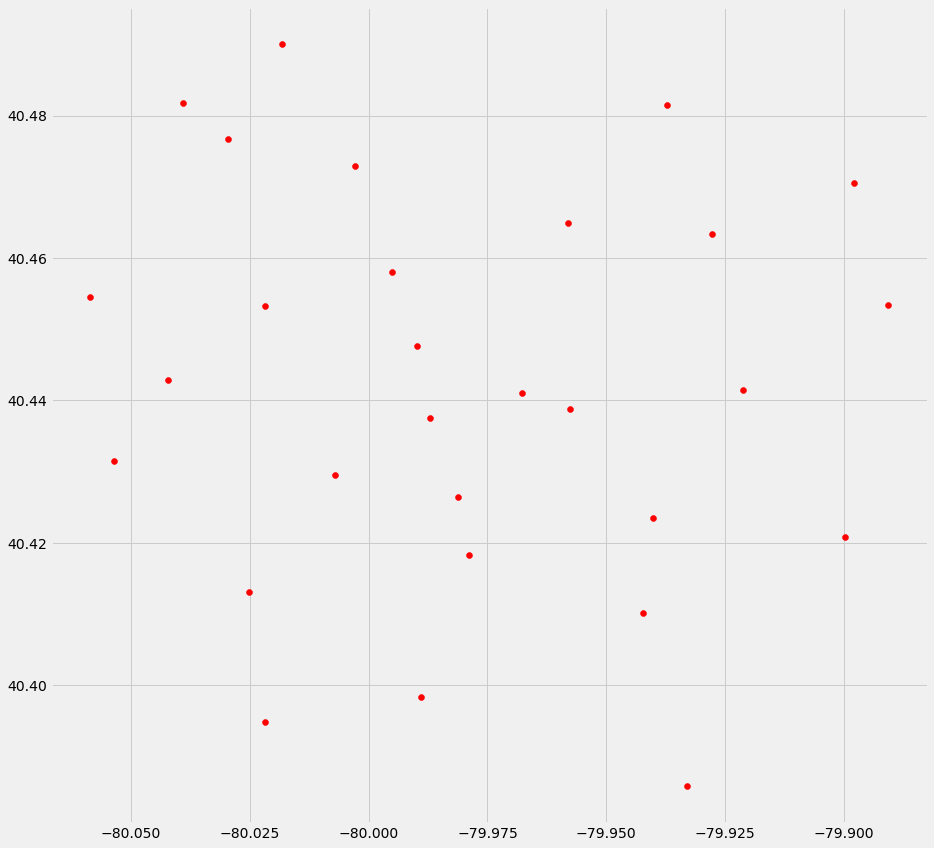

In [36]:
#takes the longitude and latitude and makes it into a scatterplot (notice how it has the same proportions as the map we used above)
x = firehouseObjective["longitude"]
y = firehouseObjective["latitude"]
fig, ax = plt.subplots(figsize = (14, 14))
plt.scatter(x = firehouseObjective.iloc[0:]["longitude"], y = firehouseObjective.iloc[0:]["latitude"], color = "red", marker = "o")
plt.show()

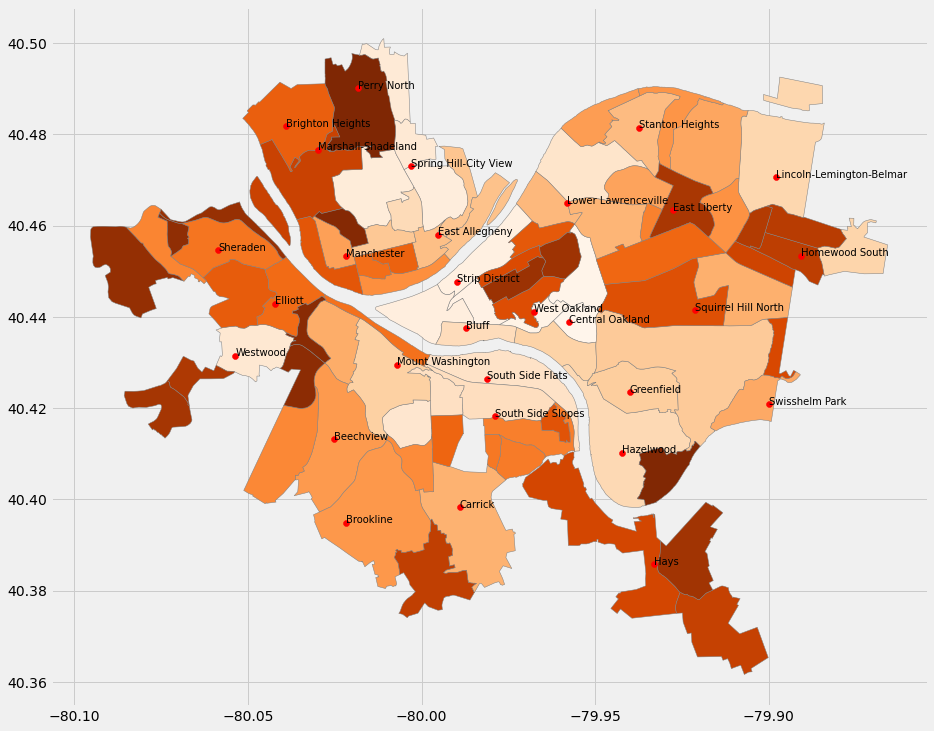

In [37]:
#this takes the map and throws the scatterplot on top of it (the points were made using the coordinates, so makes sense to use them as points on a map)
fig, ax = plt.subplots(figsize = (14, 14))
neighborhoodsMap.plot(ax = ax, color = "white", edgecolor = "grey", cmap="Oranges")
plt.scatter(x = firehouseObjective.iloc[0:]["longitude"], y = firehouseObjective.iloc[0:]["latitude"], color = "red", marker = "o")

#gives the name of the neighborhood the fire station is in
for i, firehouseNeighborhood in firehouseObjective.iterrows():    
    plt.text(firehouseNeighborhood["longitude"], firehouseNeighborhood["latitude"], firehouseNeighborhood["Neighborhood"], fontsize = 10, color = "black")
plt.show()

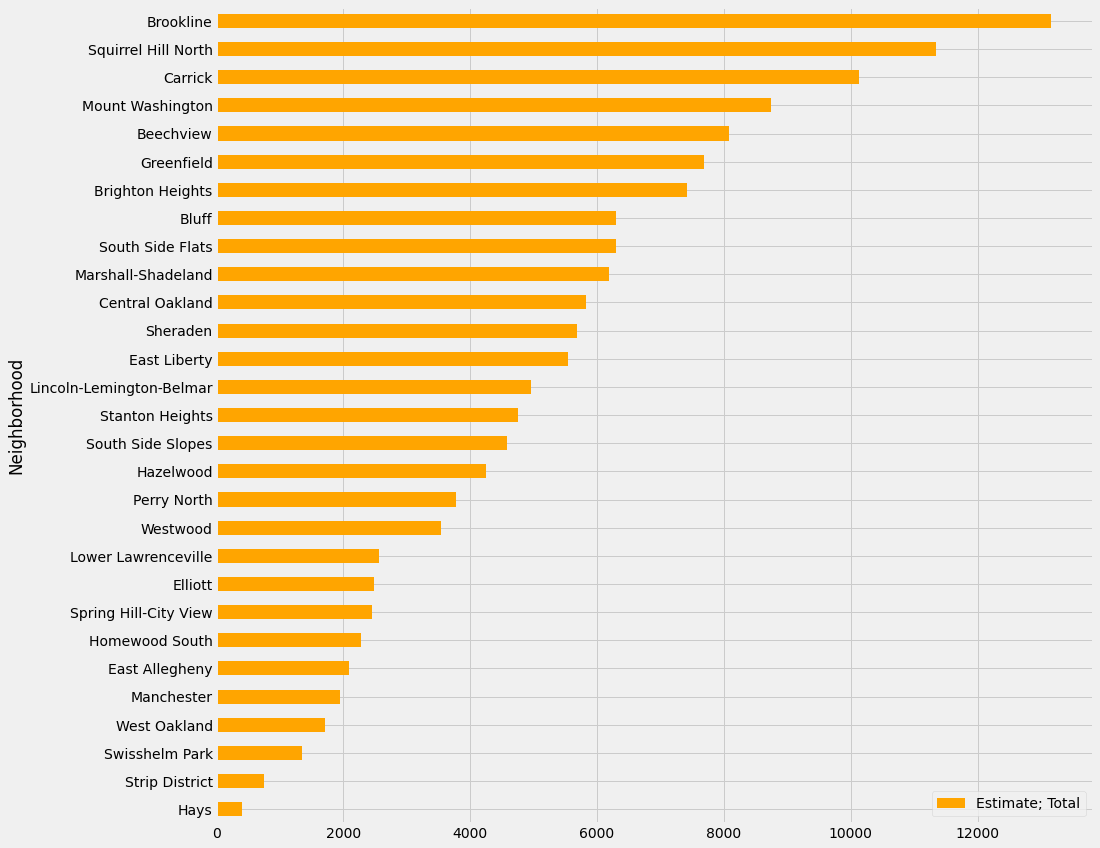

In [38]:
#makes the chart to show the the population with the lowest value being the smallest population
firehouseObjective.drop("longitude", axis = 1, inplace = True)
firehouseObjective.drop("latitude", axis = 1, inplace = True)
firehouseObjective.plot.barh(x = "Neighborhood",figsize = (14,14), color = "orange")

<strong><h1>Conclusion</h1></strong>
Using the data above, it can be concluded that Hays is the best neighborhood by my metric.  Therefore, it can also be concluded that Brookline is also the worst place to be during a fire.

In [39]:
pieArray = ['Larimer', 'Homewood North', 'Homewood South', 'Homewood West', 'Middle Hill', 'Beltzhoover', 'California-Kirkbride', 'Garfield', 'Lincoln-Lemington-Belmar', 'Perry South', 'Allentown', 'Upper Hill', 'Marshall-Shadeland', 'Fineview', 'Manchester', 'Crawford-Roberts', 'Hazelwood', 'Spring Garden', 'West Oakland', 'East Allegheny']
metricFilter = firehouseObjective.loc[firehouseObjective['Neighborhood'].isin(pieArray)]
metricFilter.iloc[0:]

,Neighborhood,Estimate; Total,name
33,West Oakland,1717.0,Firehouse 10 Medic 5
39,Manchester,1944.0,Firehouse 37
40,East Allegheny,2095.0,Firehouse 32
42,Homewood South,2276.0,Firehouse 17
67,Hazelwood,4257.0,Firehouse 13
71,Lincoln-Lemington-Belmar,4955.0,Firehouse 15
76,Marshall-Shadeland,6195.0,Firehouse 33 Truck


In [40]:
finalMetric = df3.merge(metricFilter, how = "right", left_on = "Neighborhood", right_on = "Neighborhood")
finalMetric = finalMetric.sort_values("Average x 100", ascending = False)
finalMetric.iloc[0:]

,Neighborhood,Average x 100,Estimate; Total,name
3,Homewood South,7.964602,2276.0,Firehouse 17
2,East Allegheny,6.148187,2095.0,Firehouse 32
4,Hazelwood,5.914117,4257.0,Firehouse 13
5,Lincoln-Lemington-Belmar,5.088009,4955.0,Firehouse 15
1,Manchester,3.446578,1944.0,Firehouse 37
6,Marshall-Shadeland,3.114187,6195.0,Firehouse 33 Truck
0,West Oakland,2.288871,1717.0,Firehouse 10 Medic 5


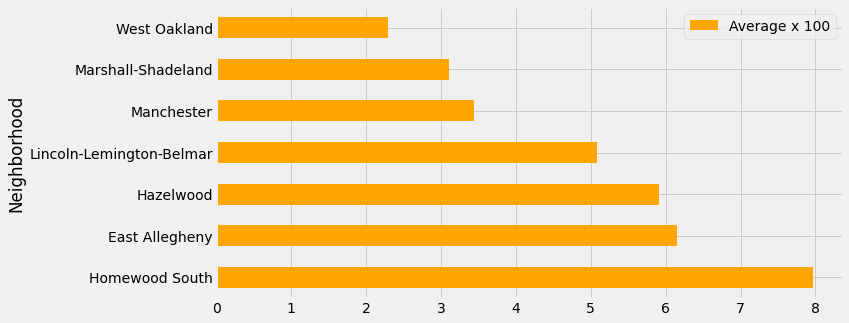

In [41]:
finalMetric.plot.barh(x = "Neighborhood", y = "Average x 100", figsize = (10,5), color = "orange")

<strong><h1>Conclusion</h1></strong>
From the data shown above, we were able to determine that Homewood South is the safest place to be in during a fire.  We used the building density in certain neighborhoods, fire department locations, and the history of fire incidents to determine this result

<strong><h1>Concluding Remarks</h1></strong>

Max:  Regarding our metric, fire safety, Homewood South is the safest. It was the most fire incidents per population since 2017, and the buildings are very spread out. This means Homewood South is the best neighborhood. Personally, I have worked in the Homewood area at a preschool and can say I've enjoyed what it has to offer. After getting to know members of the community I can say they are passionate about it as well. At the same time the crime rate is very high and it isn't the best place to be at night. However, we were only looking at fire safety and Homewood South was by far the safest.

Kameren:  Based on our combined metric, it seems that Homewood South is the safest neighborhood to be in if a fire were to occur. Personally, I have not been to Homewood South or the surrounding areas, but based on the data and pictures from the internet, it looks like a lovely place to live in.

Josh:  Considering what we learned from the final metric, Homewood South is the safest place to be during a fire.  I have not ever been to Homewood South, but I have a friend who lives in the city.  I asked him about Homewood South as a whole and he said that the crime rate there is high, so I never really thought to consider it as a candidate for the safest location